# Import libraries and define a few variables


In [1]:
#!pip install tensorflow_addons

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import random
import warnings
import pandas as pd
import tensorflow as tf
import keras
import tensorflow.keras as keras
import tensorflow_addons as tfa

from scipy.io import loadmat
from glob import glob
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalMaxPooling1D, Conv1D, ReLU, LeakyReLU, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Concatenate, Reshape, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

warnings.filterwarnings('ignore')

C:\Users\aditi\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
path_mat = glob('Training_2/*.mat')
len(path_mat)

3453

# Function for loading data

In [4]:
def load_data(filename,calib):
    
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    
    lead_1 = data[0]/calib    
    lead_2 = data[1]/calib
    lead_3 = data[2]/calib

    avr = data[3]/calib
    avl = data[4]/calib
    avf = data[5]/calib

    v1 = data[6]/calib
    v2 = data[7]/calib
    v3 = data[8]/calib
    v4 = data[9]/calib
    v5 = data[10]/calib
    v6 = data[11]/calib
    
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
        
    gender = header_data[-5][6:].split('\n')[0]
    
    dict_1 = {'lead_1': lead_1,
              'lead_2': lead_2,
              'lead_3': lead_3,
              'avr': avr,
              'avl': avl,
              'avf': avf,
              'v1': v1,
              'v2': v2,
              'v3': v3,
              'v4': v4,
              'v5': v5,
              'v6': v6} 
    
    return dict(dict_1) ,gender,header_data

# Fixed variables

In [5]:
baseline = 16
sr = 500
calib = 1000

# Creating dataset


### (Used only peaks,onsets and offsets as variables and created a dataframe with lead name as target variable)

<b>Note:</b> Takes a lot of time to generate dataframe, do not run

In [5]:
final_df=pd.DataFrame()
final_df_2=pd.DataFrame()

for file in tqdm(path_mat[:100]): #could't take all as the dataframe was taking a very long time to load
    print(file)
    extracted_data = load_data(file,calib)
    leads = extracted_data[0]
    for key in leads.keys():
        try:
            _, rpeaks = nk.ecg_peaks(leads[key], sampling_rate=sr)
            _, waves_peak = nk.ecg_delineate(leads[key], 
                                             rpeaks, 
                                             sampling_rate=sr, 
                                             method="dwt", 
                                             show=False, 
                                             show_type='all')
        
            df = pd.DataFrame(waves_peak)                       
            df['Lead'] = key                  
            
                
            final_df = final_df.append(df, ignore_index=True)
        except:
            pass      
    final_df_2 = final_df_2.append(final_df, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Training_2\Q0001.mat
Training_2\Q0002.mat
Training_2\Q0003.mat
Training_2\Q0004.mat
Training_2\Q0005.mat
Training_2\Q0006.mat
Training_2\Q0007.mat
Training_2\Q0010.mat
Training_2\Q0011.mat
Training_2\Q0012.mat
Training_2\Q0013.mat
Training_2\Q0014.mat
Training_2\Q0015.mat
Training_2\Q0016.mat
Training_2\Q0017.mat
Training_2\Q0018.mat
Training_2\Q0019.mat
Training_2\Q0020.mat
Training_2\Q0021.mat
Training_2\Q0022.mat
Training_2\Q0023.mat
Training_2\Q0024.mat
Training_2\Q0025.mat
Training_2\Q0026.mat
Training_2\Q0027.mat
Training_2\Q0028.mat
Training_2\Q0029.mat
Training_2\Q0030.mat
Training_2\Q0031.mat
Training_2\Q0032.mat
Training_2\Q0033.mat
Training_2\Q0034.mat
Training_2\Q0035.mat
Training_2\Q0036.mat
Training_2\Q0037.mat
Training_2\Q0038.mat
Training_2\Q0039.mat
Training_2\Q0040.mat
Training_2\Q0041.mat
Training_2\Q0042.mat
Training_2\Q0043.mat
Training_2\Q0044.mat
Training_2\Q0045.mat
Training_2\Q0046.mat
Training_2\Q0047.mat
Training_2\Q0048.mat
Training_2\Q0049.mat
Training_2\Q0

In [8]:
df2 = final_df_2.dropna()
df2 = df2.reset_index(drop=True)
df2

,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,Lead
0,2397.0,2383.0,2409.0,2435.0,2427.0,2482.0,2473.0,2527.0,2519.0,2538.0,lead_1
1,646.0,641.0,658.0,692.0,683.0,729.0,721.0,849.0,826.0,860.0,lead_2
2,1234.0,1229.0,1245.0,1281.0,1271.0,1317.0,1309.0,1384.0,1378.0,1393.0,lead_2
3,1523.0,1518.0,1537.0,1569.0,1560.0,1606.0,1598.0,1647.0,1638.0,1654.0,lead_2
4,2107.0,2102.0,2118.0,2153.0,2144.0,2190.0,2182.0,2310.0,2298.0,2323.0,lead_2
...,...,...,...,...,...,...,...,...,...,...,...
1224327,2514.0,2491.0,2522.0,2576.0,2564.0,2608.0,2599.0,2730.0,2688.0,2757.0,v6
1224328,2963.0,2941.0,2972.0,3026.0,3020.0,3058.0,3049.0,3180.0,3137.0,3208.0,v6
1224329,3409.0,3384.0,3418.0,3472.0,3465.0,3504.0,3495.0,3625.0,3610.0,3666.0,v6
1224330,3847.0,3841.0,3855.0,3909.0,3903.0,3941.0,3932.0,4062.0,4020.0,4090.0,v6


In [9]:
#df2.to_csv('data.csv')

# Reading data

In [6]:
df_ = pd.read_csv('data.csv',index_col=[0])

In [7]:
df_

,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,Lead
0,2397.0,2383.0,2409.0,2435.0,2427.0,2482.0,2473.0,2527.0,2519.0,2538.0,lead_1
1,646.0,641.0,658.0,692.0,683.0,729.0,721.0,849.0,826.0,860.0,lead_2
2,1234.0,1229.0,1245.0,1281.0,1271.0,1317.0,1309.0,1384.0,1378.0,1393.0,lead_2
3,1523.0,1518.0,1537.0,1569.0,1560.0,1606.0,1598.0,1647.0,1638.0,1654.0,lead_2
4,2107.0,2102.0,2118.0,2153.0,2144.0,2190.0,2182.0,2310.0,2298.0,2323.0,lead_2
...,...,...,...,...,...,...,...,...,...,...,...
1224327,2514.0,2491.0,2522.0,2576.0,2564.0,2608.0,2599.0,2730.0,2688.0,2757.0,v6
1224328,2963.0,2941.0,2972.0,3026.0,3020.0,3058.0,3049.0,3180.0,3137.0,3208.0,v6
1224329,3409.0,3384.0,3418.0,3472.0,3465.0,3504.0,3495.0,3625.0,3610.0,3666.0,v6
1224330,3847.0,3841.0,3855.0,3909.0,3903.0,3941.0,3932.0,4062.0,4020.0,4090.0,v6


In [8]:
df_.isnull().sum()

ECG_P_Peaks      0
ECG_P_Onsets     0
ECG_P_Offsets    0
ECG_Q_Peaks      0
ECG_R_Onsets     0
ECG_R_Offsets    0
ECG_S_Peaks      0
ECG_T_Peaks      0
ECG_T_Onsets     0
ECG_T_Offsets    0
Lead             0
dtype: int64

# Preprocessing

In [9]:
X = df_.drop('Lead', axis=1)
y = df_['Lead']

In [10]:
y[y == 'lead_1'] = 0
y[y == 'lead_2'] = 1
y[y == 'lead_3'] = 2

y[y == 'avr'] = 3
y[y == 'avl'] = 4
y[y == 'avf'] = 5

y[y == 'v1'] = 6
y[y == 'v2'] = 7
y[y == 'v3'] = 8
y[y == 'v4'] = 9
y[y == 'v5'] = 10
y[y == 'v6'] = 11

In [11]:
labelencoder = LabelEncoder()
y_ = to_categorical(labelencoder.fit_transform(y))

In [12]:
scaler_train, scaler_test = SS(), SS()
X_ss = scaler_train.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify = y_train)

In [14]:
X_train

array([[-0.65978373, -0.6600378 , -0.65953991, ..., -0.65339221,
        -0.65761487, -0.65089389],
       [-0.31176089, -0.31157902, -0.30831582, ..., -0.30813266,
        -0.30747357, -0.30945282],
       [-0.06555405, -0.0650823 , -0.06512571, ..., -0.07281102,
        -0.07106762, -0.07491082],
       ...,
       [ 0.7165504 ,  0.71773794,  0.71944647, ...,  0.71250304,
         0.71038962,  0.71214492],
       [-0.47342409, -0.47277908, -0.47286688, ..., -0.48136815,
        -0.47966676, -0.48373161],
       [-0.37282019, -0.37293806, -0.37377259, ..., -0.37430741,
        -0.37320079, -0.37652972]])

In [15]:
X_test

array([[-0.96901953, -0.9694086 , -0.96955047, ..., -0.96488296,
        -0.96807753, -0.96144628],
       [ 1.56092624,  1.5611597 ,  1.55962661, ...,  1.56308326,
         1.56014863,  1.56143227],
       [ 1.54425993,  1.54085819,  1.54402002, ...,  1.55324033,
         1.54818446,  1.55310444],
       ...,
       [-0.81993182, -0.81896531, -0.8213636 , ..., -0.81481619,
        -0.81269476, -0.81714768],
       [ 1.75031612,  1.74917594,  1.74993613, ...,  1.75176457,
         1.75293837,  1.75388087],
       [-0.54978609, -0.54853099, -0.55029376, ..., -0.54527146,
        -0.54554543, -0.54505473]])

In [16]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [19]:
X_tr = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1).astype('float32')
X_vd = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1).astype('float32')

y_tr = np.array(y_train).astype('float32')
y_vd = np.array(y_val).astype('float32')

In [20]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')

In [21]:
X_tr.shape,y_tr.shape

((783572, 10, 1), (783572, 12))

# Model

### Note: Due to unavailability of GPU, only trained a 1D-CNN with 1 conv block

In [22]:
dropout_rate = 0.2

model = Sequential()

model.add(Conv1D(32, 3, input_shape = X_tr.shape[1:3]))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, input_shape = X_tr.shape[1:3]))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(dropout_rate))

model.add(GlobalAveragePooling1D())
model.add(Dense(12, activation='softmax'))
model.add(Dropout(dropout_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 32)             0         
                                                                 
 batch_normalization (BatchN  (None, 8, 32)            128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             3104      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 32)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 6, 32)            128       
 hNormalization)                                        

# Training

In [24]:
optimizer_ = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer_, metrics=[
              tfa.metrics.F1Score(num_classes=12, name='f1_score'), 'accuracy'])

In [26]:
#checkpointer = ModelCheckpoint(
#    filepath='saved_checkpoints/chk.pth',
#    verbose=1,
#    save_best_only=True,
#    monitor='val_loss',
#    mode='min',
#    save_weights_only=True)

reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.5,
                                         patience=1,
                                         monitor='val_loss',
                                         mode='min',
                                         min_lr=0.0000005,
                                         verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', patience=2)

start = datetime.now()

trained_model = model.fit(X_tr,
                          y_tr,
                          batch_size=32,
                          epochs=5,
                          callbacks=[#checkpointer,
                                     reduce_lr_on_plateau, earlystopping],
                          validation_data=(X_vd, y_vd),
                          verbose=1)

print("=======" * 12, end="\n\n\n")

duration = datetime.now() - start
print("Training completed in {}".format(duration))

Epoch 1/5
24487/24487 [==============================] - ETA: 0s - loss: 5.0246 - f1_score: 0.0932 - accuracy: 0.1117
Epoch 1: val_loss improved from inf to 2.69624, saving model to saved_checkpoints\chk.pth
24487/24487 [==============================] - 68s 3ms/step - loss: 5.0246 - f1_score: 0.0932 - accuracy: 0.1117 - val_loss: 2.6962 - val_f1_score: 0.0611 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 2/5
24470/24487 [============================>.] - ETA: 0s - loss: 4.9436 - f1_score: 0.1373 - accuracy: 0.1555
Epoch 2: val_loss improved from 2.69624 to 2.29962, saving model to saved_checkpoints\chk.pth
24487/24487 [==============================] - 71s 3ms/step - loss: 4.9435 - f1_score: 0.1374 - accuracy: 0.1555 - val_loss: 2.2996 - val_f1_score: 0.1484 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 3/5
24476/24487 [============================>.] - ETA: 0s - loss: 4.9030 - f1_score: 0.1686 - accuracy: 0.1797
Epoch 3: val_loss did not improve from 2.29962

Epoch 3: ReduceLROnPlateau reduc

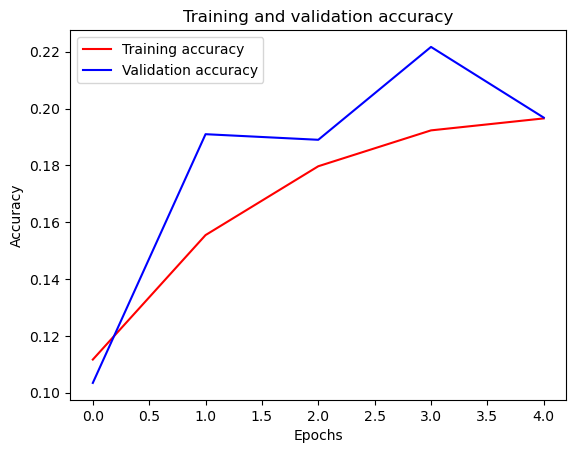

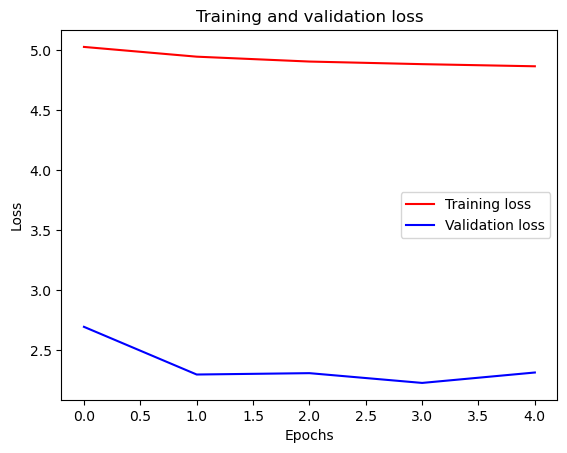

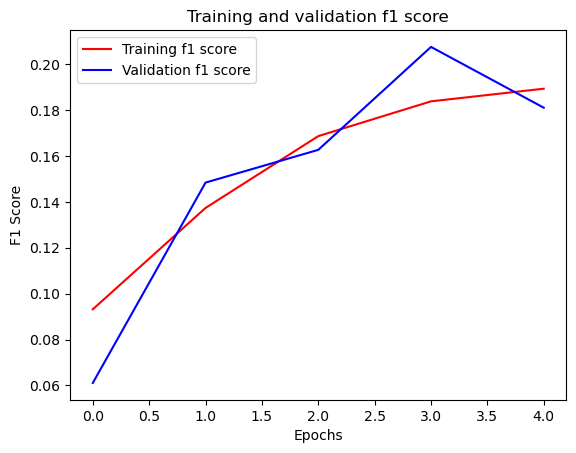

In [28]:
f1_val=trained_model.history['val_f1_score']
f1_val=np.array(f1_val)
avg_f1_val = np.mean(f1_val,axis=1)
f1_train=trained_model.history['f1_score']
f1_train=np.array(f1_train)
avg_f1_train = np.mean(f1_train,axis=1)

f1_val_=[]
for i in f1_val:
    f1_val_.append(i.mean())
f1_train_=[]
for i in f1_train:
    f1_train_.append(i.mean())

accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,5))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1_train_, 'r', label='Training f1 score')
plt.plot(epochs, f1_val_, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


# Evaluation

In [29]:
y_pred = model.predict(X_test, batch_size=1000, verbose=True)

245/245 [==============================] - 1s 3ms/step


In [36]:
correct_class = 0
total = len(y_test)

for i,j in zip(y_pred,y_test):
    if np.argmax(i) == np.argmax(j):
        correct_class += 1

In [38]:
print('Accurate preds %: ',correct_class/total)

Accurate preds %:  0.19611870934017242


# Further improvements:

- Could have calculated more features from the existing ones, like: PR duration/segment, QRS duration/segment, U wave, etc.

- Could have improved the CNN by adding more Convolutional Blocks and loss functions.